# OECD 국가의 삶의 만족도

__참고:__ 오렐리앙 제롱의 [<핸즈온 머신러닝(2판)>](https://github.com/ageron/handson-ml2) 
1장의 소스코드를 사용합니다.

## 주요 내용

1인당 [GDP(국내총생산)](https://ko.wikipedia.org/wiki/%EA%B5%AD%EB%82%B4%EC%B4%9D%EC%83%9D%EC%82%B0)와 삶의 만족도 사이의 
선형 관계를 확인한다.

In [1]:
# 모듈: 넘파이와 판다스
import numpy as np
import pandas as pd

판다스 기본 설정

In [2]:
pd.set_option('display.max_columns', None)

그래프 그리기

In [3]:
import matplotlib.pyplot as plt

## 데이터 구하기

1인당 GDP와 삶의 만족도 데이터셋은 아래 링크에서 구한다.

- 국가별 1인당 GDP 데이터: [국제통화기금(IMF)](https://ko.wikipedia.org/wiki/%EA%B5%AD%EC%A0%9C_%ED%86%B5%ED%99%94_%EA%B8%B0%EA%B8%88#:~:text=%EA%B5%AD%EC%A0%9C%20%ED%86%B5%ED%99%94%20%EA%B8%B0%EA%B8%88(%E5%9C%8B%E9%9A%9B%E9%80%9A%E8%B2%A8,%EC%9C%84%EC%9E%84%EB%B0%9B%EC%9D%80%20%EA%B5%AD%EC%A0%9C%20%EA%B8%B0%EA%B5%AC%EC%9D%B4%EB%8B%A4.)의 
['세계 경제전망 데이터베이스'](http://goo.gl/j1MSKe).
- [OECD](https://ko.wikipedia.org/wiki/%EA%B2%BD%EC%A0%9C%ED%98%91%EB%A0%A5%EA%B0%9C%EB%B0%9C%EA%B8%B0%EA%B5%AC)
회원 국가별 '삶의 만족도'(life satisfaction) 데이터:OECD의 
    ['더 나은 삶의 지수'(BLI, Better Life Index)](https://stats.oecd.org/Index.aspx?DataSetCode=BLI).

훈련 데이터 구하는 과정을 여기서는 
특정 서버에 저장된 다음 두 개의 csv 파일을 다운로드하는 것으로 대체한다.

* `gdp_per_capita_2015.csv`: IMF(국제통화기금)에 제공하는 1인당 국내총생산 데이터(GDP) 데이터
* `oecd_bli_2015.csv`: 2015년도 기준 OECD 국가들의 '더 나은 삶의 지수'(BLI) 데이터

최종적으로 아래 표와 같은 데이터를 생성해야 하는데 언급된 데이터 파일을 다운로드 하면 전혀
다른 모양의 데이터가 파일에 포함되어 있다.
이어지는 3단계에서 원본 데이터 파일에서 아래 모양의 표를 어떻게 유도해낼 수 있는지
자세히 설명한다. 
설명 이해가 어렵다면 4단계로 넘아가도 선형회귀 모델의 훈련 과정을 이해할 수 있다.
하지만 훈련 보다는 데이터를 준비하는 과정이 일반적으로 더 중요하기에 3단계를 
최대한 이해하도록 노력할 것을 권장한다.

| 국가 | 1인당 GDP(미국 달러) | 삶의 만족도 |
| :--- | :--- | :--- |
| 헝가리 | 12,240 | 4.9 |
| 한국 | 27,195 | 5.8 |
| 프랑스 | 37,675 | 6.5 |
| 호주 | 50,9672 | 7.3 |
| 미국 | 55,805 | 7.2 |

### 3단계: 데이터 적재, 정제, 전처리

컴퓨터에 저장된 또는 다운로드된 데이터는 일반적으로 바로 모델 훈련에 사용할 수 없으며, 
데이터 적재, 데이터 정제, 데이터 전처리 등의 과정을 거쳐야 비로소 모델 훈련에 활용될 수 있다.

* __데이터 적재__(data loading): 서버에 존재하거나 컴퓨터에 저장되어 있는 파일을 
    특정 자료형의 값으로 불러오는 과정

* __데이터 정제__(data cleaning): 적재된 데이터 셋에 포함된 오류, 부정확한 값, 
    누락된 값, 상관없는 값 등을 제거, 수정, 보완하는 과정

* __데이터 전처리__(data preprocessing): 정제된 데이터 셋을 모델 훈련에 적절한 형식으로 변환하거나
    적절한 내용의 데이터를 추가하거나 삭제하는 과정

#### 1인당 GDP 데이터 적재, 정제, 전처리

2015년 기준 국가별 1인당 GDP 관련 데이터가 저장되어 있는 서버 주소는 다음과 같다.

In [4]:
datapath = "https://raw.githubusercontent.com/codingalzi/handson-ml3/master/notebooks/data/lifesat/"

판다스의 `read_csv()` 함수는 지정된 경로에 저장된 csv 을 판다스의 데이터프레임 객체로 적재한다.
적재할 때 사용되는 옵션 인자는 다음과 같다.

- `thousands=','`: 1000단위로 쉼표 찍기
- `delimiter='\t'`: 탭(tab)으로 열 구분
- `encoding='latin1'`: 인코딩 방식 지정. 파일에서 사용된 'C&ocirc;te d'Ivoire'(코트디브와르)와 같은 특수 알파벳을 사용하는 국가명 처리 용도임.
- `na_values="n/a"`: 결측치를 'NaN'으로 처리.

In [5]:
gdp_per_capita_2015 = pd.read_csv(datapath + "gdp_per_capita_2015.csv", 
                             thousands=',', 
                             delimiter='\t',
                             encoding='latin1', 
                             na_values="n/a")

총 190개 국가의 1인당 GDP 정보를 담고 있다.

In [6]:
gdp_per_capita_2015

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0
...,...,...,...,...,...,...,...
185,Vietnam,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2088.344,2012.0
186,Yemen,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1302.940,2008.0
187,Zambia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1350.151,2010.0
188,Zimbabwe,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1064.350,2012.0


국가명을 행 인덱스로 지정한다.

In [7]:
gdp_per_capita_2015.set_index("Country", inplace=True)

gdp_per_capita_2015

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0
...,...,...,...,...,...,...
Vietnam,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2088.344,2012.0
Yemen,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1302.940,2008.0
Zambia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1350.151,2010.0


이어서 1인당 GDP 데이터임을 명시하기 위해 열 이름 `"2015"`를 `"GDP per capita"`로 변경한다.

In [8]:
gdp_per_capita_2015.rename(columns={"2015": "GDP per capita"}, inplace=True) 

gdp_per_capita_2015.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


#### 삶의 만족도 데이터 적재, 정제, 전처리

OECD 국가별 삶의 만족도 데이터는 '더 나은 삶의 지수' 데이터 파일에 포함되어 있다. 
따라서 먼저 해당 csv 파일을 판다스의 데이터프레임 객체로 불러온 후에 
삶의 만족도와 관련된 내용을 추출하는 과정을 밟는다.

- `pandas.read_csv()` 함수는 지정한 경로에 저장되어 있는 csv 파일을 다운로드하여 바로 데이터프레임 객체를
생성한다.

In [9]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')

생성된 데이터프레임의 모양은 다음과 같다.

In [10]:
oecd_bli.shape

(3292, 17)

처음 5행를 살펴보자.

In [11]:
oecd_bli.head()

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.2,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.9,NaN,NaN


국가별 삶의 만족도는 측정지표(`'Indicator'`) 라벨을 갖는 열에서
`'Life satisfaction'`이라는 항목과 연관된다.
총 24 종의 측정지표가 사용되며 그중에 하나임을 다음과 같이 확인할 수 있다.

In [12]:
'Life satisfaction' in oecd_bli.Indicator.unique()

True

24 종의 측정지표가 사용된다.

In [13]:
oecd_bli.Indicator.unique().shape

(24,)

각 측정지표는 다음과 같다.

In [14]:
oecd_bli.Indicator.unique()

array(['Dwellings without basic facilities', 'Housing expenditure',
       'Rooms per person', 'Household net adjusted disposable income',
       'Household net financial wealth', 'Employment rate',
       'Job security', 'Long-term unemployment rate', 'Personal earnings',
       'Quality of support network', 'Educational attainment',
       'Student skills', 'Years in education', 'Air pollution',
       'Water quality', 'Consultation on rule-making', 'Voter turnout',
       'Life expectancy', 'Self-reported health', 'Life satisfaction',
       'Assault rate', 'Homicide rate',
       'Employees working very long hours',
       'Time devoted to leisure and personal care'], dtype=object)

그런데 삶의 만족도와 관련된 행이 OECD 회원국의 수인 37보다 많다.
이는 삶의 만족도와 관련해서 데이터의 중복이 있다는 것을 의미한다. 

In [15]:
mask = oecd_bli.Indicator == 'Life satisfaction'
oecd_life_sat = oecd_bli[mask]

In [16]:
oecd_life_sat

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
2669,AUS,Australia,SW_LIFS,Life satisfaction,L,Value,TOT,Total,AVSCORE,Average score,0,units,NaN,NaN,7.3,NaN,NaN
2670,AUT,Austria,SW_LIFS,Life satisfaction,L,Value,TOT,Total,AVSCORE,Average score,0,units,NaN,NaN,6.9,NaN,NaN
2671,BEL,Belgium,SW_LIFS,Life satisfaction,L,Value,TOT,Total,AVSCORE,Average score,0,units,NaN,NaN,6.9,NaN,NaN
2672,CAN,Canada,SW_LIFS,Life satisfaction,L,Value,TOT,Total,AVSCORE,Average score,0,units,NaN,NaN,7.3,NaN,NaN
2673,CZE,Czech Republic,SW_LIFS,Life satisfaction,L,Value,TOT,Total,AVSCORE,Average score,0,units,NaN,NaN,6.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843,CHL,Chile,SW_LIFS,Life satisfaction,L,Value,LW,Low,AVSCORE,Average score,0,units,NaN,NaN,6.0,NaN,NaN
2844,EST,Estonia,SW_LIFS,Life satisfaction,L,Value,LW,Low,AVSCORE,Average score,0,units,NaN,NaN,5.1,NaN,NaN
2845,RUS,Russia,SW_LIFS,Life satisfaction,L,Value,LW,Low,AVSCORE,Average score,0,units,NaN,NaN,5.4,NaN,NaN
2846,SVN,Slovenia,SW_LIFS,Life satisfaction,L,Value,LW,Low,AVSCORE,Average score,0,units,NaN,NaN,5.0,NaN,NaN


In [17]:
oecd_life_sat.shape

(179, 17)

무엇이 중복되었는지를 알아내기 위해 
OECD 회원국가별로 `'Indicator'` 열에 포함된 24개 측정지표에 해당하는 값(value)만을 따로 추출해보자.
즉, ['더 나은 삶의 지수'(BLI, Better Life Index) 자료](https://stats.oecd.org/Index.aspx?DataSetCode=BLI)에서
볼 수 있는 아래 테이블 이미지와 같은 데이터프레임을 생성하고자 한다. 

- 행: OECD 회원국(`Country`)
- 열: 측정지표(`Indicator`)
- 항목 값: 국가별 지표 수치(`Value`)

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/oecd_bli.png"/></div>

이를 위해 국가명(`'Country'` 열의 항목)을 행의 인덱스 이름으로, 
`'Indicator'`의 항목을 열의 인덱스 이름으로 사용하는 데이터프레임을 생성한다.
해당 열과 항목에 해당하는 값은 `'Value'` 열에 포함된 값을 사용한다.

그런데 OECD의 원본 파일에는 각 측정지표의 값으로 국가별 소득 불평등(`'INEQUALITY'`)과 관련된 다섯 가지 
기준에 따라 다른 값이 포함되어 있다(위 이미지 좌상단 화살표 참조).

| 기준   | 기호 | 대상     |
| :---  | :---| :---    |
| Total | TOT | 전체 인구 |
| Men   | MN  | 남성     |
| Wemen | WMN | 여성     |
| High  | HGH | 상위 소득 |
| Low   | LW  | 하위 소득 |

In [18]:
oecd_bli.INEQUALITY.unique()

array(['TOT', 'MN', 'WMN', 'HGH', 'LW'], dtype=object)

`oecd_bli.INEQUALITY == 'TOT'` 인 경우만 사용한다.

In [19]:
mask = oecd_bli.INEQUALITY == 'TOT'
oecd_bli = oecd_bli[mask]

888개로 샘플 수가 줄었다. 

In [20]:
oecd_bli.shape

(888, 17)

여전히 888개의 데이터가 있는 이유는 '더 나은 삶'을 측정는 지표가 24종이고 37개의 OECD 회원국별로 조사했기 때문이다.
실제로 다음이 성립한다.

In [21]:
37 * 24 == 888

True

즉, `Country` 열에 37개의 국가가 각각 24번 사용되며 그때마다 다른 측정지표가 사용된다.
예를 들어, 대한민국(Korea)가 24번 사용된 것을 다음과 같이 확인한다.

In [22]:
(oecd_bli['Country'] == 'Korea').sum()

24

**`pivot()` 메서드**

국가명(`'Country'` 열의 항목)을 행 인덱스의 라벨로, 
`'Indicator'`의 항목을 열 인덱스 라벨로 사용하면서
해당 행과 열의 항목에는 `'Value'` 열에 포함된 값을 사용하는 데이터프레임을
`pivot()` 메서드를 이용하여 생성한다.

In [23]:
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

이제 총 37개 국가의 측정지표별 수치를 확인하면 다음과 같다.

In [24]:
oecd_bli

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,Housing expenditure,Job security,Life expectancy,Life satisfaction,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,20.0,4.8,82.1,7.3,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,21.0,3.9,81.0,6.9,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,21.0,5.0,80.5,6.9,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,21.0,4.6,73.7,7.0,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,21.0,6.4,81.5,7.3,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2
Chile,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,18.0,4.4,78.9,6.7,1.59,22101.0,86.0,1.2,59.0,436.0,14.41,49.0,73.0,16.5
Czech Republic,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,26.0,4.1,78.2,6.5,3.12,20338.0,85.0,1.4,60.0,500.0,14.98,59.0,85.0,18.1
Denmark,15.0,3.9,7.0,0.9,78.0,2.03,73.0,0.3,26491.0,44488.0,24.0,5.6,80.1,7.5,1.78,48347.0,95.0,1.9,72.0,498.0,16.06,88.0,94.0,19.4
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,19.0,5.2,76.5,5.6,3.82,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5


참고로 대한민국의 측정지표별 수치는 다음과 같다(위 이미지 중간의 파란띠로 구분된 영역 참조).

In [25]:
oecd_bli.loc['Korea']

Indicator
Air pollution                                   30.00
Assault rate                                     2.10
Consultation on rule-making                     10.40
Dwellings without basic facilities               4.20
Educational attainment                          82.00
Employees working very long hours               18.72
Employment rate                                 64.00
Homicide rate                                    1.10
Household net adjusted disposable income     19510.00
Household net financial wealth               29091.00
Housing expenditure                             16.00
Job security                                     3.20
Life expectancy                                 81.30
Life satisfaction                                5.80
Long-term unemployment rate                      0.01
Personal earnings                            36354.00
Quality of support network                      72.00
Rooms per person                                 1.40
Self-reported heal

알파벳 순으로 첫 5개 국가의 삶의 만족도는 `"Life satisfaction"` 열(column)에서 확인할 수 있다.

In [26]:
oecd_bli["Life satisfaction"].head()

Country
Australia    7.3
Austria      6.9
Belgium      6.9
Brazil       7.0
Canada       7.3
Name: Life satisfaction, dtype: float64

## 데이터 합병

앞서 살펴본 대로 1인당 GDP 데이터는 OECD 회원국 이외의 국가 데이터도 포함되어 있다.
OECD 회원국으로 제한해서 1인당 GDP와 삶의 만족도 사이의 관계를 파악하기 위해
앞서 구한 두 개의 데이터프레임을 하나로 합병한다.

- 판다스의 `merge()` 함수를 이용한다. 
- OECD 회원국들만 대상으로 하기 위해 
    `left_index=True`와 `right_index=True`로 설정한다.

In [32]:
gdp_per_capita_2015.shape

(190, 6)

In [34]:
oecd_bli.shape

(37, 24)

In [35]:
oecd_country_stats = pd.merge(left=gdp_per_capita_2015['GDP per capita'],
                              right=oecd_bli['Life satisfaction'], 
                              left_index=True, right_index=True)

In [36]:
oecd_country_stats

,GDP per capita,Life satisfaction
Country,,
Australia,50961.865,7.3
Austria,43724.031,6.9
Belgium,40106.632,6.9
Brazil,8669.998,7.0
Canada,43331.961,7.3
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Denmark,52114.165,7.5
Estonia,17288.083,5.6


In [38]:
oecd_bli.index

Index(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Korea', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway',
       'OECD - Total', 'Poland', 'Portugal', 'Russia', 'Slovak Republic',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey',
       'United Kingdom', 'United States'],
      dtype='object', name='Country')

In [37]:
oecd_country_stats.shape

(36, 2)

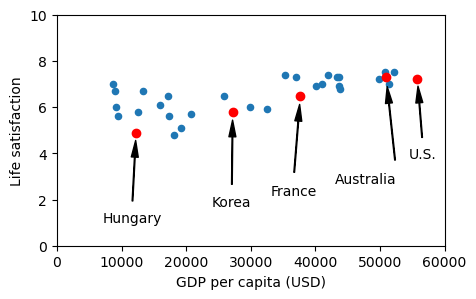

In [31]:
oecd_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])

# 언급된 5개 국가명과 좌표
position_text = {
    "Hungary": (7000, 1),
    "Korea": (24000, 1.7),
    "France": (33000, 2.2),
    "Australia": (43000, 2.7),
    "United States": (54500, 3.8),
}

# 5개 국가는 좌표를 이용하여 빨강색 점으로 표기
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = oecd_country_stats.loc[country]            # 5개 국가의 지표
    
    # 5개 국가명 표기
    country = "U.S." if country == "United States" else country  # 미국은 U.S. 로 표기
    
    # 화살표 그리기
    plt.annotate(country, xy=(pos_data_x, pos_data_y), 
                 xytext=pos_text,
                 arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5) )
    
    # 5개 국가 산점도 그리기: 빨강색 점
    plt.plot(pos_data_x, pos_data_y, "ro")

# x 축 제목 새롭게 지정
plt.xlabel("GDP per capita (USD)")

plt.show()